In [1]:
import b3d
import jax.numpy as jnp
import os
from b3d import Mesh, Pose
import jax
import genjax
from genjax import Pytree
import rerun as rr
from b3d.modeling_utils import uniform_discrete, uniform_pose, gaussian_vmf
import matplotlib.pyplot as plt
from functools import partial
import importlib
from ipywidgets import interact
import ipywidgets as widgets
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from genjax import SelectionBuilder as S


In [281]:
b3d.rr_init("slam")
key = jax.random.PRNGKey(0)

In [3]:
room_h, room_w = 1.0, 1.0
line_segments = jnp.array(
    [
        [0.0, 0.0, room_w, 0.0, 1.0, 0.0, 0.0],
        [0.0, 0.0, 0, room_h, 0.0, 1.0, 0.0],
        [room_w, 0.0, room_w, room_h, 0.0, 0.0, 1.0],
        [0.0, room_h, room_w, room_h, 1.0, 1.0, 0.0],
    ]
)
epsilon = 0.003
line_segments = jnp.concatenate(
    [
        line_segments,
        line_segments
        + jnp.array([room_w + epsilon, 0.0, room_w + epsilon, 0.0, 0.0, 0.0, 0.0]),
        line_segments
        + jnp.array(
            [
                (room_w + epsilon) * 2.0,
                0.0,
                (room_w + epsilon) * 2.0,
                0.0,
                0.0,
                0.0,
                0.0,
            ]
        ),
    ],
    axis=0,
)

world_height = 0.5


def line_segment_to_mesh(line_segment):
    a, b, c, d, r1, g1, b1 = line_segment
    vertices = jnp.array(
        [
            [a, world_height / 2, b],
            [a, -world_height / 2, b],
            [c, -world_height / 2, d],
            [c, world_height / 2, d],
        ]
    )
    faces = jnp.array(
        [
            [0, 1, 3],
            [3, 1, 2],
        ]
    )
    vertex_attributes = jnp.ones((len(vertices), 3)) * jnp.array([r1, g1, b1])
    return Mesh(vertices, faces, vertex_attributes)


world_mesh = Mesh.squeeze_mesh(jax.vmap(line_segment_to_mesh)(line_segments))
world_mesh.rr_visualize("mesh")

In [4]:
b3d.reload(b3d.renderer.renderer_original)
renderer = b3d.renderer.renderer_original.RendererOriginal()

In [319]:
import b3d.chisight.dense.dense_model
b3d.reload(b3d.chisight.dense.dense_model)
b3d.reload(b3d.utils)
import b3d.chisight.dense.likelihoods.blur_likelihood
b3d.reload(b3d.chisight.dense.likelihoods.blur_likelihood)
intermediate_likelihood_func = b3d.chisight.dense.likelihoods.blur_likelihood.blur_intermediate_likelihood_func
blur_intermediate_sample_func = b3d.chisight.dense.likelihoods.blur_likelihood.blur_intermediate_sample_func
model, viz_trace, info_from_trace = (
    b3d.chisight.dense.dense_model.make_dense_multiobject_model(
        renderer, intermediate_likelihood_func, blur_intermediate_sample_func
    )
)
importance_jit = jax.jit(model.importance)

color_variance_sweep = jnp.linspace(0.1, 0.4, 5)
outlier_probability_sweep = jnp.linspace(0.05, 0.4, 5)
blur_sweep = jnp.linspace(0.1, 100.0, 15)

w = 1.2
wz = 1.0
high, low, num = (
    jnp.array([w, wz, -jnp.pi / 4]),
    jnp.array([-w, -wz, jnp.pi / 4]),
    jnp.array([15, 15, 7]),
)
base_grid_points = b3d.utils.make_grid_points(low, high, num)
grid_points_to_poses = jax.jit(jax.vmap(
    lambda x: Pose(
        jnp.array([x[0], 0.0, x[1]]),
        b3d.Rot.from_rotvec(jnp.array([0.0, x[2], 0.0])).as_quat()
    )
))

In [350]:
IDX = 4
k = 50
keys = jax.random.split(key, 2 * k)
rows = jax.vmap(genjax.categorical.sample,in_axes=(0, 0,))(
        keys[:k],
        jnp.ones((k, renderer.height)))
cols = jax.vmap(genjax.categorical.sample,in_axes=(0, 0,))(
        keys[k:],
        jnp.ones((k, renderer.width)))

likelikood_args = {
    "fx": renderer.fx,
    "fy": renderer.fy,
    "cx": renderer.cx,
    "cy": renderer.cy,
    "rows":  rows,
    "cols": cols,
}

gt_camera_pose = Pose.from_translation(jnp.array([1.81, 0.0, 0.21]))
rgbd = renderer.render_rgbd_from_mesh(world_mesh.transform(gt_camera_pose.inv()))

latent_camera_pose = Pose.from_translation(jnp.array([1.87, 0.0, 0.21]))
choicemap = genjax.ChoiceMap.d(
    {
        "rgbd": rgbd,
        "camera_pose": latent_camera_pose,
        "object_pose_0": Pose.identity(),
        "color_variance_0": 0.1,
        "depth_variance_0": 0.01,
        "outlier_probability_0": 0.01,
        "blur": 100.0,
    }
)

key = jax.random.PRNGKey(0)
trace = importance_jit(
    key,
    choicemap,
    (
        {
            "num_objects": Pytree.const(1),
            "meshes": [world_mesh],
            "likelihood_args": likelikood_args,
        },
    ),
)[0]

print(trace.get_score())


viz_trace(trace)
# viz_trace(importance_jit(
#     key,
#     trace.get_choices().filter( ~S["rgbd"]),
#     trace.get_args(),
# )[0])
info = info_from_trace(trace)

465.5283


In [351]:
key = b3d.split_key(key)
addresses= Pytree.const(("color_variance_0","outlier_probability_0","blur"))
sweeps = [color_variance_sweep, outlier_probability_sweep, blur_sweep]
scores = b3d.utils.grid_trace(
    trace,
    addresses,
    sweeps,
)
index = jnp.unravel_index(scores.argmax(), scores.shape)
print(color_variance_sweep[index[0]], outlier_probability_sweep[index[1]], blur_sweep[index[2]])

sampled_indices = jax.vmap(jnp.unravel_index, in_axes=(0, None))(
    jax.random.categorical(key, scores.reshape(-1), shape=(1000,)), scores.shape
)
sampled_parameters = jnp.vstack(
    [sweep[indices] for indices, sweep in zip(sampled_indices, sweeps)]
).T
print(sampled_parameters[:10])
trace = b3d.update_choices(trace, key, addresses, *sampled_parameters[0])
viz_trace(importance_jit(
    key,
    trace.get_choices().filter( ~S["rgbd"]),
    trace.get_args(),
)[0])

0.1 0.05 100.0
[[1.0000000e-01 5.0000001e-02 3.5778572e+01]
 [1.0000000e-01 5.0000001e-02 2.8642859e+01]
 [1.0000000e-01 5.0000001e-02 2.1507145e+01]
 [1.0000000e-01 5.0000001e-02 7.1457146e+01]
 [1.0000000e-01 5.0000001e-02 1.4371429e+01]
 [1.0000000e-01 5.0000001e-02 3.5778572e+01]
 [1.0000000e-01 5.0000001e-02 4.2914291e+01]
 [1.0000000e-01 5.0000001e-02 1.4371429e+01]
 [1.0000000e-01 5.0000001e-02 2.8642859e+01]
 [1.0000000e-01 5.0000001e-02 7.2357149e+00]]


35.778572
[0.0022     0.0002     0.0522     0.018      0.0002     0.0204
 0.0002     0.086      0.0074     0.0038     0.0022     0.0362
 0.0004     0.003      0.0002     0.0002     0.015      0.0092
 0.0036     0.0002     0.0266     0.0004     0.0562     0.0002
 0.0216     0.0024     0.0002     0.0174     0.0002     0.0108
 0.0002     0.0008     0.0002     0.0024     0.0216     0.0812
 0.0002     0.0036     0.0026     0.0162     0.0008     0.0016
 0.0572     0.0002     0.0002     0.0022     0.0872     0.0082
 0.0456     0.002      0.0054     0.015      0.009      0.0008
 0.0098     0.0004     0.0232     0.001      0.0002     0.016
 0.0154     0.0114     0.004      0.0004     0.0012     0.07780001
 0.0002     0.0104     0.0282     0.0026     0.0032     0.0328
 0.0006    ]
[[0.6219511  0.         0.12200843]
 [0.685223   0.         0.35903233]
 [1.7048395  0.         0.21661425]
 [2.6113417  0.         0.23236495]
 [2.5802963  0.         0.32910216]
 [2.6608315  0.         0.2553216 ]
 [

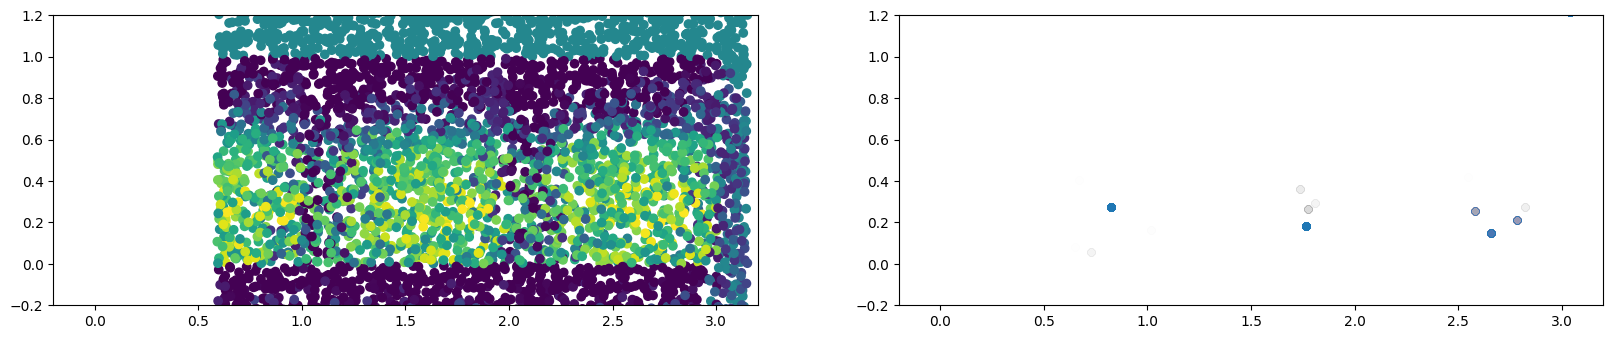

In [352]:
print(trace.get_choices()["blur"])
address = Pytree.const(("camera_pose",))
traces = [trace]



all_poses = []
all_scores = []
key = b3d.split_key(key)
grid_noise  = (jax.random.uniform(key, base_grid_points.shape) - 0.5) * (high - low) /num
pose_grid = grid_points_to_poses(base_grid_points + grid_noise)
poses = trace.get_choices()["camera_pose"] @ pose_grid

scores = b3d.enumerate_choices_get_scores(
    trace, key,
    Pytree.const(("camera_pose",)), poses,
)
all_poses.append(poses)
all_scores.append(scores)

all_poses = Pose.concatenate_poses(all_poses)
all_scores = jnp.concatenate(all_scores)

# subplots 2
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].scatter(
    all_poses.pos[:, 0],
    all_poses.pos[:, 2],
    c=all_scores,
)
new_trace = b3d.update_choices(trace, key, address, sampled_poses[0])
viz_trace(new_trace)

border = 0.2
ax[0].set_xlim(0.0 - border,3.0 + border)
ax[0].set_ylim(0.0 - border,1.0 + border)
ax[0].set_aspect("equal")

sampled_indices = jax.random.categorical(key, all_scores * 0.25 , shape=(5000,))
sampled_indices_unique, counts = jnp.unique(sampled_indices, return_counts=True)
# sampled_poses = all_poses[sampled_indices_unique]
print(counts / counts.sum())
print(all_poses[sampled_indices_unique].pos)
sampled_poses = poses[sampled_indices]
im = ax[1].scatter(
    sampled_poses.pos[:, 0],
    sampled_poses.pos[:, 2],
    # c=counts,
    alpha = 0.005
)
ax[1].set_xlim(0.0 - border,3.0 + border)
ax[1].set_ylim(0.0 - border,1.0 + border)
# fig.colorbar(im, ax=ax[1])
ax[1].set_aspect("equal")
# ax[1].colorbar()

# print(sampled_indices_unique)
# for (t,i) in enumerate(sampled_indices_unique):
#     new_trace = b3d.update_choices(trace, key, Pytree.const(("camera_pose",)), poses[i])
#     print(new_trace.get_choices()["camera_pose"])
#     viz_trace(new_trace,t )

In [291]:
poses[sampled_indices_unique]

Pose(position=Array([[1.6102762 , 0.        , 0.19126539],
       [1.7036885 , 0.        , 0.05698447],
       [1.720757  , 0.        , 0.24772902],
       [2.7327766 , 0.        , 0.33607262],
       [0.81344736, 0.        , 0.17533374]], dtype=float32), quaternion=Array([[ 0.        ,  0.12248261,  0.        ,  0.9924707 ],
       [ 0.        ,  0.0516438 ,  0.        ,  0.9986656 ],
       [ 0.        ,  0.06694181,  0.        ,  0.9977569 ],
       [ 0.        ,  0.06058854,  0.        ,  0.9981628 ],
       [ 0.        , -0.02487117,  0.        ,  0.99969065]],      dtype=float32))

[412 532 533 589 621]
Pose(position=Array([1.6102762 , 0.        , 0.19126539], dtype=float32), quaternion=Array([0.        , 0.12248261, 0.        , 0.9924707 ], dtype=float32))
Pose(position=Array([1.7036885 , 0.        , 0.05698447], dtype=float32), quaternion=Array([0.       , 0.0516438, 0.       , 0.9986656], dtype=float32))
Pose(position=Array([1.720757  , 0.        , 0.24772902], dtype=float32), quaternion=Array([0.        , 0.06694181, 0.        , 0.9977569 ], dtype=float32))
Pose(position=Array([2.7327766 , 0.        , 0.33607262], dtype=float32), quaternion=Array([0.        , 0.06058854, 0.        , 0.9981628 ], dtype=float32))
Pose(position=Array([0.81344736, 0.        , 0.17533374], dtype=float32), quaternion=Array([ 0.        , -0.02487117,  0.        ,  0.99969065], dtype=float32))


(-0.2, 1.2)

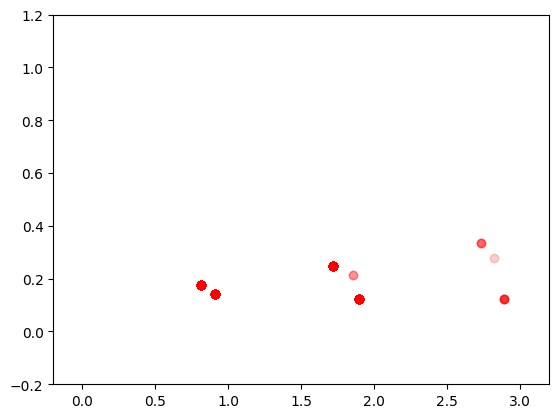

In [199]:
sampled_indices = jax.random.categorical(key, scores * 0.05 , shape=(5000,))
sampled_poses = poses[sampled_indices]
plt.scatter(
    sampled_poses.pos[:, 0],
    sampled_poses.pos[:, 2],
    c="red",
    alpha = 0.1
)
border = 0.2
plt.xlim(0.0 - border,3.0 + border)
plt.ylim(0.0 - border,1.0 + border)

In [110]:
key = b3d.split_key(key)
addresses= Pytree.const(("color_variance_0","outlier_probability_0","blur"))
sweeps = [color_variance_sweep, outlier_probability_sweep, blur_sweep]
scores = b3d.utils.grid_trace(
    trace,
    addresses,
    sweeps,
)
index = jnp.unravel_index(scores.argmax(), scores.shape)
print(color_variance_sweep[index[0]], outlier_probability_sweep[index[1]], blur_sweep[index[2]])

sampled_indices = jax.vmap(jnp.unravel_index, in_axes=(0, None))(
    jax.random.categorical(key, scores.reshape(-1), shape=(1000,)), scores.shape
)
sampled_parameters = jnp.vstack(
    [sweep[indices] for indices, sweep in zip(sampled_indices, sweeps)]
).T
print(sampled_parameters[:10])
trace = b3d.update_choices(trace, key, addresses, *sampled_parameters[0])
viz_trace(importance_jit(
    key,
    trace.get_choices().filter( ~S["rgbd"]),
    trace.get_args(),
)[0])

0.1 0.05 7.235715
[[1.0000000e-01 5.0000001e-02 3.5778572e+01]
 [1.0000000e-01 5.0000001e-02 1.4371429e+01]
 [1.0000000e-01 5.0000001e-02 2.1507145e+01]
 [1.0000000e-01 5.0000001e-02 7.1457146e+01]
 [1.0000000e-01 5.0000001e-02 1.4371429e+01]
 [1.0000000e-01 5.0000001e-02 3.5778572e+01]
 [1.0000000e-01 5.0000001e-02 4.2914291e+01]
 [1.0000000e-01 5.0000001e-02 1.4371429e+01]
 [1.0000000e-01 5.0000001e-02 2.8642859e+01]
 [1.0000000e-01 5.0000001e-02 7.2357149e+00]]


35.778572


(0.0, 1.0)

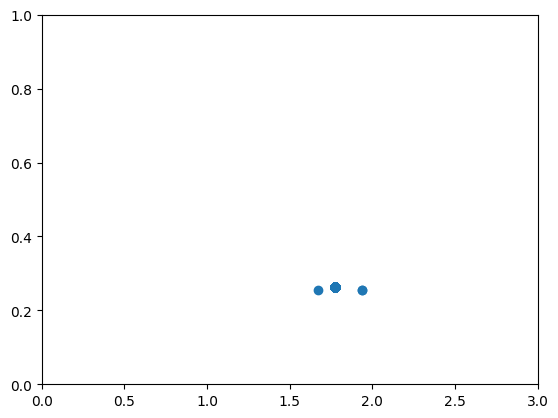

In [113]:
print(trace.get_choices()["blur"])
key = b3d.split_key(key)
address = Pytree.const(("camera_pose",))
traces = [trace]

grid_noise  = (jax.random.uniform(key, base_grid_points.shape) * ((high - low)/num) - (high - low)/num/2)
pose_grid = grid_points_to_poses(base_grid_points + grid_noise)
poses = trace.get_choices()["camera_pose"] @ pose_grid

scores = b3d.enumerate_choices_get_scores(
    trace, key,
    Pytree.const(("camera_pose",)), poses,
)
sampled_indices = jax.random.categorical(key, scores , shape=(1000,))
sampled_poses = poses[sampled_indices]

plt.scatter(
    sampled_poses.pos[:, 0],
    sampled_poses.pos[:, 2],
)

plt.xlim(0.0,3.0)
plt.ylim(0.0,1.0)

85.72858


100%|██████████| 40/40 [00:02<00:00, 16.03it/s]


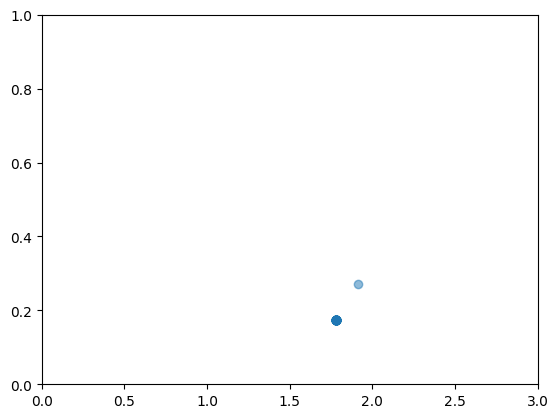

In [108]:
import jax.random

print(trace.get_choices()["blur"])
key = b3d.split_key(key)
address = Pytree.const(("camera_pose",))
traces = [trace]

grid_noise  = (jax.random.uniform(key, base_grid_points.shape) * ((high - low)/num) - (high - low)/num/2)
pose_grid = grid_points_to_poses(base_grid_points + grid_noise)
poses = trace.get_choices()["camera_pose"] @ pose_grid

for _ in tqdm(range(40)):
    scores = b3d.enumerate_choices_get_scores(
        trace, key,
        Pytree.const(("camera_pose",)), poses,
    )
    sampled_indices = jax.random.categorical(key, scores , shape=(1000,))
    sampled_pose = poses[sampled_indices[0]]
    # sampled_pose = poses[scores.argmax()]
    trace = b3d.update_choices(trace, key, address, sampled_pose)
    traces.append(trace)

poses = Pose.stack_poses([trace.get_choices()["camera_pose"] for trace in traces])

plt.xlim(0.0,3.0)
plt.ylim(0.0,1.0)
viz_trace(trace)

plt.scatter(poses.pos[:, 0], poses.pos[:, 2], alpha=0.5)

In [134]:
viz_trace(trace)

In [102]:
key = b3d.split_key(key)
addresses= Pytree.const(("color_variance_0","outlier_probability_0","blur"))
sweeps = [color_variance_sweep, outlier_probability_sweep, blur_sweep]
scores = b3d.utils.grid_trace(
    trace,
    addresses,
    sweeps,
)
index = jnp.unravel_index(scores.argmax(), scores.shape)
print(color_variance_sweep[index[0]], outlier_probability_sweep[index[1]], blur_sweep[index[2]])

sampled_indices = jax.vmap(jnp.unravel_index, in_axes=(0, None))(
    jax.random.categorical(key, scores.reshape(-1), shape=(1000,)), scores.shape
)
sampled_parameters = jnp.vstack(
    [sweep[indices] for indices, sweep in zip(sampled_indices, sweeps)]
).T
print(sampled_parameters[:10])
trace = b3d.update_choices(trace, key, addresses, *sampled_parameters[0])
# plt.plot(color_variance_sweep, scores)

# addresses= Pytree.const(("blur",))
# blur_sweep_dense = jnp.linspace(1.0, 10.0, 200)
# scores = scores = b3d.enumerate_choices_get_scores(
#     trace,
#     key,
#     addresses,
#     blur_sweep_dense,
# )
# plt.plot(blur_sweep_dense, scores)
# print(blur_sweep_dense[scores.argmax()])

0.25 0.05 7.235715
[[2.5000000e-01 5.0000001e-02 2.1507145e+01]
 [2.5000000e-01 5.0000001e-02 3.5778572e+01]
 [2.5000000e-01 5.0000001e-02 4.2914291e+01]
 [2.5000000e-01 5.0000001e-02 9.2864288e+01]
 [2.5000000e-01 5.0000001e-02 9.2864288e+01]
 [2.5000000e-01 5.0000001e-02 1.4371429e+01]
 [2.5000000e-01 5.0000001e-02 4.2914291e+01]
 [1.7500001e-01 5.0000001e-02 5.7185719e+01]
 [2.5000000e-01 5.0000001e-02 6.4321434e+01]
 [2.5000000e-01 5.0000001e-02 6.4321434e+01]]


In [ ]:
grid_noise  = (jax.random.uniform(key, base_grid_points.shape) * ((high - low)/num) - (high - low)/num/2)
pose_grid = grid_points_to_poses(base_grid_points + grid_noise)
plt.scatter(
    pose_grid.pos[:, 0],
    pose_grid.pos[:, 2],
)

1.0
[106 127 148] [191 363 446]
[1.8059995] [0.21]


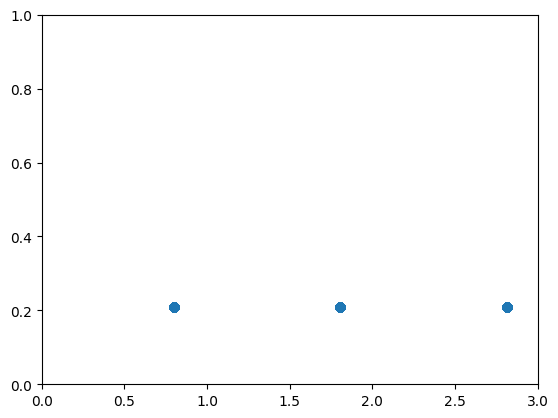

In [143]:
import jax.random

print(trace.get_choices()["blur"])
key = b3d.split_key(key)
address = Pytree.const(("camera_pose",))
offset_pose = Pose.from_translation(jnp.array([0.01, 0.0, 0.0]))
poses = trace.get_choices()["camera_pose"] @ pose_grid @ offset_pose

scores = scores = b3d.enumerate_choices_get_scores(
    trace,
    key,
    Pytree.const(("camera_pose",)),
    poses,
)

sampled_indices = jax.random.categorical(key, scores , shape=(1000,))

sampled_indices_unique, counts = jnp.unique(sampled_indices, return_counts=True)

sampled_pose = poses[sampled_indices[0]]

print(sampled_indices_unique, counts)

trace = b3d.update_choices(trace, key, address, sampled_pose)

viz_trace(trace)

print(
    poses.pos[sampled_indices, 0][:1], poses.pos[sampled_indices, 2][:1]
)
plt.xlim(0.0,3.0)
plt.ylim(0.0,1.0)
plt.scatter(poses.pos[sampled_indices, 0], poses.pos[sampled_indices, 2], alpha=0.5)

In [418]:
sortorder = (-scores).argsort()
print(scores[sortorder[:10]])
i = 1
sampled_pose = poses[sortorder[i]]
print(scores[i])
print(sampled_pose)
new_trace = b3d.update_choices(trace, key, address, sampled_pose)
viz_trace(new_trace)

[129840.22  129819.8   129808.336 129764.98  129646.734 129485.59
 129443.98  129353.016 129022.56  128892.7  ]
28258.71
Pose(position=Array([0.79199994, 0.        , 0.21      ], dtype=float32), quaternion=Array([0., 0., 0., 1.], dtype=float32))


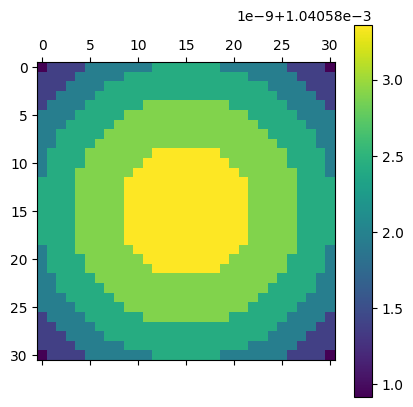

In [412]:
def log_gaussian_kernel(size: int, sigma: float) -> jnp.ndarray:
    """Creates a 2D Gaussian kernel."""
    ax = jnp.arange(-size // 2 + 1.0, size // 2 + 1.0)
    xx, yy = jnp.meshgrid(ax, ax)
    kernel = -(xx**2 + yy**2) / (2.0 * sigma**2)
    kernel = kernel - jax.nn.logsumexp(kernel)
    return kernel

plt.matshow(jnp.exp(log_gaussian_kernel(31, 10000.0)))
plt.colorbar()

In [413]:
jnp.exp(log_gaussian_kernel(31, 10000.0))

Array([[0.00104058, 0.00104058, 0.00104058, 0.00104058, 0.00104058,
        0.00104058, 0.00104058, 0.00104058, 0.00104058, 0.00104058,
        0.00104058, 0.00104058, 0.00104058, 0.00104058, 0.00104058,
        0.00104058, 0.00104058, 0.00104058, 0.00104058, 0.00104058,
        0.00104058, 0.00104058, 0.00104058, 0.00104058, 0.00104058,
        0.00104058, 0.00104058, 0.00104058, 0.00104058, 0.00104058,
        0.00104058],
       [0.00104058, 0.00104058, 0.00104058, 0.00104058, 0.00104058,
        0.00104058, 0.00104058, 0.00104058, 0.00104058, 0.00104058,
        0.00104058, 0.00104058, 0.00104058, 0.00104058, 0.00104058,
        0.00104058, 0.00104058, 0.00104058, 0.00104058, 0.00104058,
        0.00104058, 0.00104058, 0.00104058, 0.00104058, 0.00104058,
        0.00104058, 0.00104058, 0.00104058, 0.00104058, 0.00104058,
        0.00104058],
       [0.00104058, 0.00104058, 0.00104058, 0.00104058, 0.00104058,
        0.00104058, 0.00104058, 0.00104058, 0.00104058, 0.00104058,
      

In [389]:
a = scores.sort()
print(a[-2:])
b3d.normalize_log_scores(a[-2:])

[81557.3   81578.016]


Array([1.004526e-09, 1.000000e+00], dtype=float32)

[635 643 651] [165 249 586]


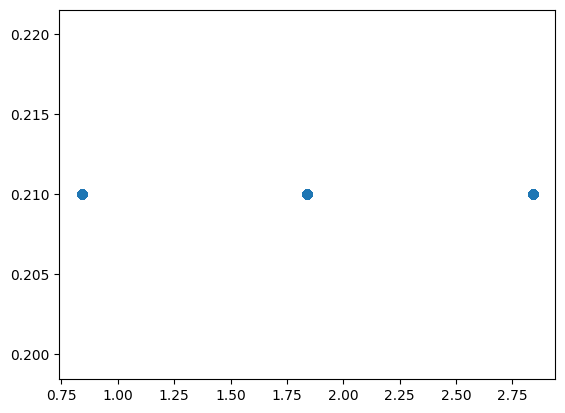

In [287]:
sampled_indices = jax.random.categorical(key, scores * 0.2, shape=(1000,))

sampled_indices_unique, counts = jnp.unique(sampled_indices, return_counts=True)
sampled_pose = poses[sampled_indices[0]]
print(sampled_indices_unique, counts)
sampled_trace = b3d.update_choices(trace, key, address, sampled_pose)
viz_trace(sampled_trace)

plt.scatter(grid[sampled_indices, 0], grid[sampled_indices, 2], alpha=0.5)

In [204]:
blur_sweep

Array([ 0.01     ,  0.5357895,  1.061579 ,  1.5873685,  2.113158 ,
        2.6389472,  3.164737 ,  3.6905265,  4.2163157,  4.7421055,
        5.2678947,  5.7936845,  6.3194737,  6.8452635,  7.371053 ,
        7.8968425,  8.422632 ,  8.9484215,  9.474211 , 10.       ],      dtype=float32)

In [ ]:
observed_camera_pose = Pose.from_translation(jnp.array([0.81, 0.0, 0.21]))
latent_camera_pose = Pose.from_translation(jnp.array([0.83, 0.0, 0.21]))
observed_rgb = renderer.render_rgbd_from_mesh(
    world_mesh.transform(observed_camera_pose.inv())
)[..., :3]
latent_rgb = renderer.render_rgbd_from_mesh(
    world_mesh.transform(latent_camera_pose.inv())
)[..., :3]

b3d.rr_log_rgb("image", observed_rgb)
b3d.rr_log_rgb("image/latent", latent_rgb)

scores = likelihood_vmap_blur(observed_rgb, latent_rgb, {"blur": blur_sweep})
print(scores)
# b3d.rr_log_depth("b", likelihood_per_pixel(observed_rgb, latent_rgb, 0.01))
# b3d.rr_log_depth("b/higher_noise", likelihood_per_pixel(observed_rgb, latent_rgb, 10.0))
# # b3d.rr_log_depth("b/diff", likelihood_per_pixel(observed_rgb, latent_rgb, 0.01) - likelihood_per_pixel(observed_rgb, latent_rgb, 1.0))

# blur_sweep = jnp.linspace(0.01, 10.5, 100)
# scores = likelihood_vmap_blur(observed_rgb, latent_rgb, blur_sweep)
# print(blur_sweep[scores.argmax()])
# plt.plot(blur_sweep, scores)

15.189407


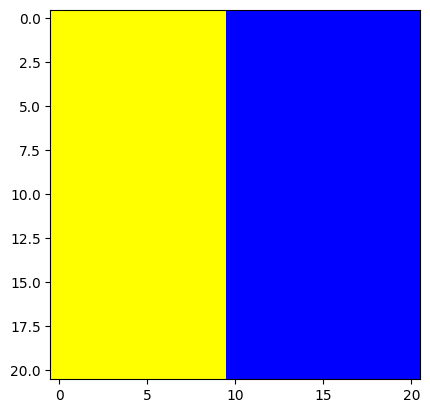

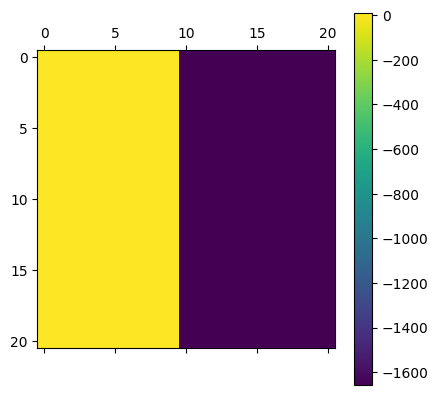

In [144]:
latent_rgb_padded = jnp.pad(
    latent_rgb,
    (
        (filter_size, filter_size),
        (filter_size, filter_size),
        (0, 0),
    ),
    mode="edge",
)
jj, ii = jnp.meshgrid(
    jnp.arange(observed_rgb.shape[1]), jnp.arange(observed_rgb.shape[0])
)
indices = jnp.stack([ii, jj], axis=-1)
ij = jnp.array([54, 65])


latent_rgb_padded_window = jax.lax.dynamic_slice(
    latent_rgb_padded,
    (ij[0], ij[1], 0),
    (2 * filter_size + 1, 2 * filter_size + 1, 3),
)
scores_inlier = genjax.truncated_normal.logpdf(
    observed_rgb[ij[0], ij[1], :], latent_rgb_padded_window, 0.03, 0.0, 1.0
).sum(-1)
plt.imshow(latent_rgb_padded_window)
plt.matshow(scores_inlier)
plt.colorbar()

blur = 0.01
log_kernel = gaussian_kernel(2 * filter_size + 1, blur)
averaged_prob = jax.nn.logsumexp(jax.nn.logsumexp(scores_inlier + log_kernel))
averaged_prob = jax.nn.logsumexp(jax.nn.logsumexp(scores_inlier + log_kernel))
print(averaged_prob)

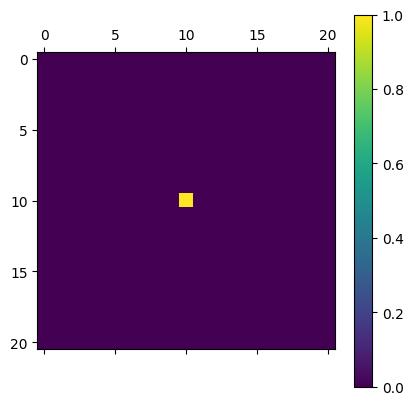

In [148]:
plt.matshow(log_kernel)
plt.colorbar()

-1656.8243


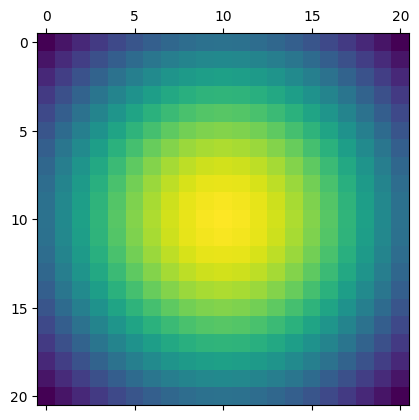

In [133]:
print(
    genjax.truncated_normal.logpdf(
        jnp.array([1.0, 1.0, 0.0]), jnp.array([0.0, 0.0, 1.0]), 0.03, 0.0, 1.0
    ).sum(-1)
)

log_kernel = gaussian_kernel(2 * filter_size + 1, blur)
plt.matshow(log_kernel)

In [130]:
b3d.rr_log_depth("b", likelihood_per_pixel(observed_rgb, latent_rgb, 0.01))
b3d.rr_log_depth("b/higher_noise", likelihood_per_pixel(observed_rgb, latent_rgb, 10.0))
# b3d.rr_log_depth("b/diff", likelihood_per_pixel(observed_rgb, latent_rgb, 0.01) - likelihood_per_pixel(observed_rgb, latent_rgb, 1.0))

-2696.628
0.9999998


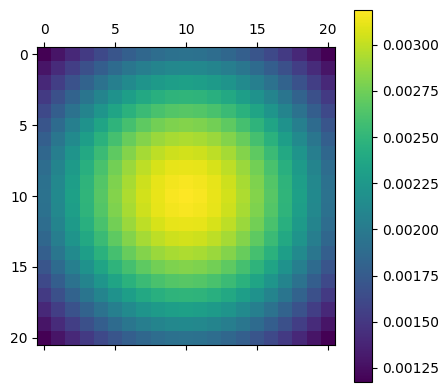

In [127]:
blur = 10.0
kernel = log_gaussian_kernel(2 * filter_size + 1, blur)
print(kernel.sum())
plt.matshow(jnp.exp(kernel))
plt.colorbar()
print(jnp.exp(kernel).sum())

In [16]:
lower_bound = jnp.array([0.0, 0.0, 0.0, 0.0])
upper_bound = jnp.array([1.0, 1.0, 1.0, 3.0])
convert_rgbd_to_color_space = lambda x: x
convert_color_space_to_rgbd = lambda x: x


# convert_rgbd_to_color_space = lambda x: b3d.colors.rgbd_to_labd(x)
# convert_color_space_to_rgbd = lambda x: b3d.colors.labd_to_rgbd(x)
def intermediate_likelihood_func(observed_rgbd, latent_rgbd, likelihood_args):
    k = likelihood_args["k"].const
    fx = likelihood_args["fx"]
    fy = likelihood_args["fy"]

    outlier_probability_0 = likelihood_args[f"outlier_probability_0"]
    # lightness_variance_0 = likelihood_args[f"lightness_variance_0"]
    color_variance_0 = likelihood_args[f"color_variance_0"]
    # depth_variance_0 = likelihood_args[f"depth_variance_0"]

    inlier_variances_0 = jnp.array(
        [color_variance_0, color_variance_0, color_variance_0, color_variance_0]
    )
    outlier_variances = jnp.array([1000000.0, 1000000.0, 1000000.0, 1000000.0])

    image_height, image_width = observed_rgbd.shape[:2]

    blur = likelihood_args["blur"]
    observed_color_space_d = apply_gaussian_blur_rgbd(
        observed_rgbd[..., :3], blur, kernel_size
    )
    latent_color_space_d = apply_gaussian_blur_rgbd(observed_rgb, blur, kernel_size)

    scores_inlier = genjax.truncated_normal.logpdf(
        observed_color_space_d, latent_color_space_d, color_variance_0, 0.0, 1.0
    ) + jnp.log(1.0 - outlier_probability_0)
    scores_outlier = genjax.truncated_normal.logpdf(
        observed_color_space_d, 0.5, 0.1, 0.0, 1.0
    ) + jnp.log(outlier_probability_0)
    print(scores_inlier.shape)
    print(scores_outlier.shape)

    return {
        "score": pixelwise_score.sum(),
        "observed_color_space_d": observed_color_space_d,
        "latent_color_space_d": latent_color_space_d,
        "pixelwise_score": pixelwise_score,
    }

    # subset_observed = observed_color_space_d
    # subset_observed_rescaled = (subset_observed - lower_bound) / (
    #     upper_bound - lower_bound
    # )
    # rendered_values_rescaled = (latent_color_space_d - lower_bound) / (
    #     upper_bound - lower_bound
    # )

    # scores_inlier = jax.vmap(
    #     genjax.truncated_normal.logpdf, in_axes=(0, 0, None, None, None)
    # )(subset_observed_rescaled, rendered_values_rescaled, inlier_variances_0, 0.0, 1.0)
    # scores_outlier = jax.vmap(
    #     genjax.truncated_normal.logpdf, in_axes=(0, None, None, None, None)
    # )(subset_observed_rescaled, 0.5, outlier_variances, 0.0, 1.0)

    # scores_inlier_merged = scores_inlier[..., :3].sum(-1) + jnp.log(
    #     1.0 - outlier_probability_0
    # )
    # scores_outlier_merged = scores_outlier[..., :3].sum(-1) + jnp.log(
    #     outlier_probability_0
    # )

    # pixelwise_score = jnp.logaddexp(scores_inlier_merged, scores_outlier_merged)
    # pixelwise_score_full = jnp.zeros((image_height, image_width))
    # pixelwise_score_full = pixelwise_score

    return {
        "score": pixelwise_score_full.sum(),
        # "score": (
        #     jax.nn.logsumexp(pixelwise_score_full) - jnp.log(pixelwise_score_full.size)
        # )
        # * k,
        "observed_color_space_d": observed_color_space_d,
        "latent_color_space_d": latent_color_space_d,
        "pixelwise_score": pixelwise_score_full,
    }


import b3d.chisight.dense.dense_model

b3d.reload(b3d.chisight.dense.dense_model)
model, viz_trace, info_from_trace = (
    b3d.chisight.dense.dense_model.make_dense_multiobject_model(
        renderer, intermediate_likelihood_func
    )
)
importance_jit = jax.jit(model.importance)


grid1 = b3d.multivmap(b3d.update_choices_get_score, (False, False, False, True))
grid2 = b3d.multivmap(b3d.update_choices_get_score, (False, False, False, True, True))
grid3 = b3d.multivmap(
    b3d.update_choices_get_score, (False, False, False, True, True, True)
)
grid4 = b3d.multivmap(
    b3d.update_choices_get_score, (False, False, False, True, True, True, True)
)

In [32]:
IDX = 4
key = jax.random.PRNGKey(0)
likelikood_args = {
    "fx": renderer.fx,
    "fy": renderer.fy,
    "cx": renderer.cx,
    "cy": renderer.cy,
    "k": Pytree.const(50),
}

T = 22
choicemap = genjax.ChoiceMap.d(
    {
        "rgbd": rgbd,
        "object_pose_0": Pose.identity(),
        "camera_pose": Pose.from_translation(
            gt_camera_pose.pos + jnp.array([0.1, 0.0, -0.01])
        ),
        # "outlier_probability_0": 0.1,
        # "color_variance_0": 0.2,
    }
)

trace = importance_jit(
    key,
    choicemap,
    (
        {
            "num_objects": Pytree.const(1),
            "meshes": [world_mesh],
            "likelihood_args": likelikood_args,
        },
    ),
)[0]
print(trace.get_score())
viz_trace(trace)

13398.95


[641] [1000]


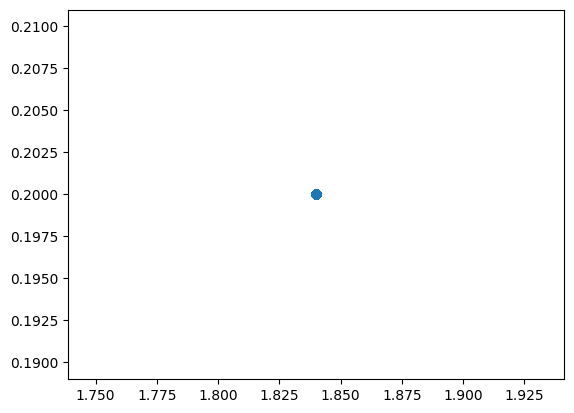

In [34]:
import jax.random

key = b3d.split_key(key)

gt_translation = trace.get_choices()["camera_pose"].pos
w = 3.1
wz = 1.0
grid = b3d.utils.make_grid_points(
    jnp.array([gt_translation[0] - w, gt_translation[1], gt_translation[2] - wz]),
    jnp.array([gt_translation[0] + w, gt_translation[1], gt_translation[2] + wz]),
    jnp.array([41, 1, 31]),
)
poses = Pose.from_translation(grid)
address = Pytree.const(("camera_pose",))
scores = grid1(trace, key, Pytree.const(("camera_pose",)), poses)
sampled_indices = jax.random.categorical(key, scores, shape=(1000,))

# print(sampled_indices)
sampled_indices_unique, counts = jnp.unique(sampled_indices, return_counts=True)
sampled_pose = poses[sampled_indices[0]]
print(sampled_indices_unique, counts)
sampled_trace = b3d.update_choices(trace, key, address, sampled_pose)
viz_trace(sampled_trace)

plt.scatter(grid[sampled_indices, 0], grid[sampled_indices, 2], alpha=0.5)

In [ ]:
plt.scatter(poses.pos[:, 0], poses.pos[:, 2], c=scores)
plt.colorbar()

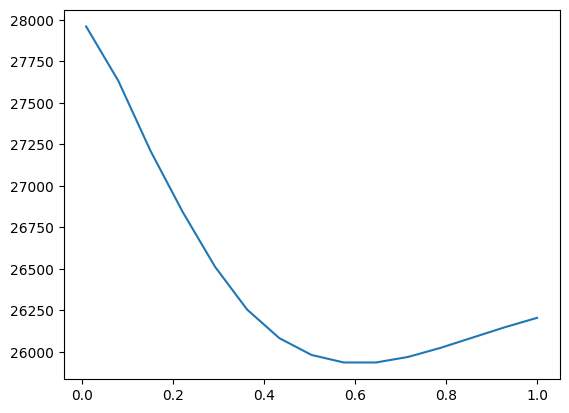

In [397]:
scores = b3d.enumerate_choices_get_scores(
    trace,
    key,
    Pytree.const(("blur",)),
    blur_sweep,
)
plt.plot(blur_sweep, scores)

In [33]:
outlier_probability_sweep = jnp.linspace(0.001, 0.2, 30)
color_variance_sweep = jnp.linspace(0.1, 0.3, 15)
blur_sweep = jnp.linspace(0.01, 1.0, 15)

for arguments in [
    Pytree.const(
        (
            "outlier_probability_background",
            "color_variance_background",
        )
    ),
]:
    key = jax.random.split(key, 2)[-1]

    # arguments = Pytree.const(("outlier_probability_background", "lightness_variance_background", "color_variance_background", "depth_variance_background",))
    sweeps = [
        outlier_probability_sweep,
        color_variance_sweep,
        # blur_sweep,
    ]

    scores = grid2(trace, key, arguments, *sweeps)
    sampled_indices = jax.vmap(jnp.unravel_index, in_axes=(0, None))(
        jax.random.categorical(key, scores.reshape(-1), shape=(1000,)), scores.shape
    )
    sampled_parameters = jnp.vstack(
        [sweep[indices] for indices, sweep in zip(sampled_indices, sweeps)]
    ).T

    print(sampled_parameters[0])
    trace = b3d.update_choices(
        trace,
        key,
        arguments,
        # 0.05, 1.0, 0.02, 0.01
        *sampled_parameters[0],
    )
    print(trace.get_score())
    viz_trace(trace)
    info_from_trace(trace)["score"]

[0.09706897 0.24285716]
13398.95


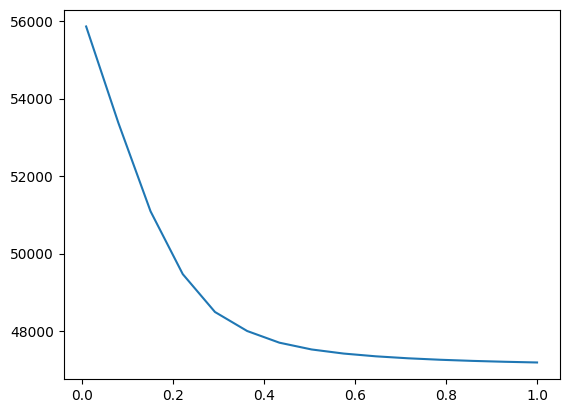

In [316]:
scores = b3d.enumerate_choices_get_scores(
    trace,
    key,
    Pytree.const(("blur",)),
    blur_sweep,
)
plt.plot(blur_sweep, scores)

In [1]:
import jax.random

key = b3d.split_key(key)

gt_translation = trace.get_choices()["camera_pose"].pos
w = 3.1
wz = 1.0
grid = b3d.utils.make_grid_points(
    jnp.array([gt_translation[0] - w, gt_translation[1], gt_translation[2] - wz]),
    jnp.array([gt_translation[0] + w, gt_translation[1], gt_translation[2] + wz]),
    jnp.array([41, 1, 31]),
)
poses = Pose.from_translation(grid)
address = Pytree.const(("camera_pose",))
scores = grid1(trace, key, Pytree.const(("camera_pose",)), poses)
sampled_indices = jax.random.categorical(key, scores, shape=(1000,))

# print(sampled_indices)
sampled_indices_unique, counts = jnp.unique(sampled_indices, return_counts=True)
sampled_pose = poses[sampled_indices[0]]
print(sampled_indices_unique, counts)
sampled_trace = b3d.update_choices(trace, key, address, sampled_pose)
viz_trace(sampled_trace)

plt.scatter(grid[sampled_indices, 0], grid[sampled_indices, 2], alpha=0.5)

NameError: name 'b3d' is not defined

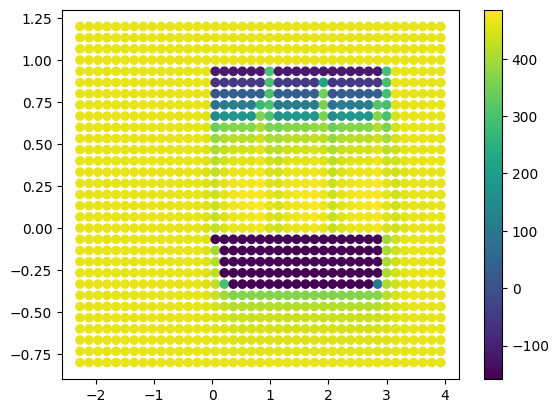

In [200]:
plt.scatter(poses.pos[:, 0], poses.pos[:, 2], c=scores)
plt.colorbar()

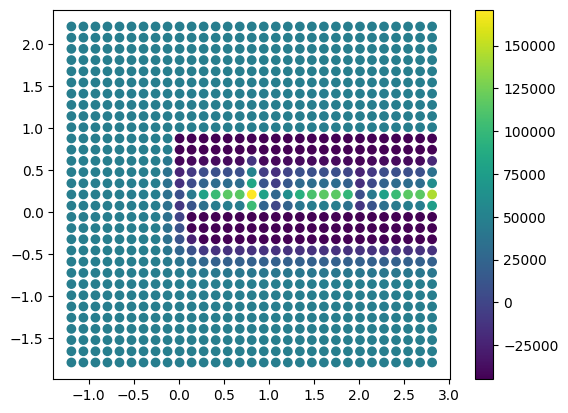

In [9]:
import trimesh

mesh = trimesh.load("identical_rooms_single_mesh.obj")
# mesh = Mesh.from_obj("identical_rooms_single_mesh.obj")
mesh.vertices

TrackedArray([[-1.025,  0.   ,  1.02 ],
              [-1.025,  0.   ,  1.02 ],
              [-1.025,  0.   ,  1.02 ],
              [-1.025,  0.   ,  1.02 ],
              [-1.025,  0.   , -1.   ],
              [-1.025,  0.   , -1.   ],
              [-1.025,  0.   , -1.   ],
              [-1.025, -2.   , -1.   ],
              [-1.025, -2.   , -1.   ],
              [-1.025, -2.   , -1.   ],
              [-1.025, -2.   ,  1.02 ],
              [-1.025, -2.   ,  1.02 ],
              [-1.025, -2.   ,  1.02 ],
              [-1.025, -2.   ,  1.02 ],
              [-3.015, -2.   , -1.   ],
              [-3.015, -2.   , -1.   ],
              [-3.015, -2.   , -1.   ],
              [-3.015,  0.   , -1.   ],
              [-3.015,  0.   , -1.   ],
              [-3.015,  0.   , -1.   ],
              [-3.015, -2.   ,  1.   ],
              [-3.015, -2.   ,  1.   ],
              [-3.015, -2.   ,  1.   ],
              [-3.015,  0.   ,  1.   ],
              [-3.015,  0.   ,  1.   ],


In [4]:
b3d.rr_init("slam")

In [7]:
obj = Mesh.from_obj("identical_rooms_single_mesh.obj")
obj.rr_visualize("mesh")

TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'